<a href="https://colab.research.google.com/github/esemlak/esemlak/blob/main/Copy_of_V2_general_purpose_csv_tensorflow_model_trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
#! unzip /content/colab_train.zip
!pip3 install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
DATASET_PATH = "/content/colab_train.csv"
LABEL_NAME = "SCORE"

# "r" for regression and "c" for classification
# for classification, the number of output nodes is automatically determined
TASK = "r"

# don't change the dummy batch size. There is a small bug in tensorflow.
# to get around that bug, dummy batch size is used
DUMMY_BATCH_SIZE = 5
BATCH_SIZE = 100
EPOCHS = 100
TRAIN_FRAC = 0.8

CHECKPOINT_DIR = "/content/"

In [36]:
from collections import defaultdict
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import kerastuner as kt

import IPython

# This function will give us a fresh dataset object

In [37]:
def get_dataset(batch_size = 5):
    return tf.data.experimental.make_csv_dataset(
        DATASET_PATH,
        batch_size = batch_size,
        label_name = LABEL_NAME,
        num_epochs = 1
    )

# If classification, Find Number of labels (for output nodes)

In [38]:
if TASK == "r":
    OUTPUT_NODES = 1

elif TASK == "c":
    unique_labels = set()

    for _, label in get_dataset(batch_size=BATCH_SIZE):
        for ele in label.numpy():
            unique_labels.add(ele)

    num_labels = len(unique_labels)

    if num_labels <= 2:
        OUTPUT_NODES = 1
    else:
        OUTPUT_NODES = num_labels
    
    print(unique_labels)

print("output nodes: ", OUTPUT_NODES)

output nodes:  1


**Test**

In [39]:
model_inputs = {}

#dataset = tf.data.experimental.make_csv_dataset(
#        DATASET_PATH,
#        batch_size = DUMMY_BATCH_SIZE,
#        label_name = LABEL_NAME,
#        num_epochs = 1,
#        header = True,
#    )

#iterator = dataset.as_numpy_iterator()
#print(next(iterator))

# Creating the Model Inputs as a dictionary

In [40]:
model_inputs = {}

for batch, _ in tf.data.experimental.make_csv_dataset(
        DATASET_PATH,
        batch_size = DUMMY_BATCH_SIZE,
        label_name = LABEL_NAME,
        num_epochs = 1
    ).take(1):
    print("test " ,  batch.items())

for batch, _ in get_dataset(batch_size=DUMMY_BATCH_SIZE).take(1):
    for col_name, col_values in batch.items():
        model_inputs[col_name] = tf.keras.Input(shape=(1,), name=col_name, dtype=col_values.dtype)

test  odict_items([('X1', <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.63856465, 0.7064689 , 0.30769232, 0.26417354, 0.3775881 ],
      dtype=float32)>), ('Y1', <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.23209961, 0.23210773, 0.5       , 0.7601229 , 0.43335083],
      dtype=float32)>), ('X2', <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.7471154 , 0.7695262 , 0.7471154 , 0.20941535, 0.4307051 ],
      dtype=float32)>), ('Y2', <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.45546874, 0.76789075, 0.5445312 , 0.76789075, 0.515615  ],
      dtype=float32)>), ('X3', <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.       , 0.6923077, 0.6923077, 0.       , 0.       ],
      dtype=float32)>), ('Y3', <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0. , 0.5, 0.5, 0. , 0. ], dtype=float32)>), ('X4', <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.       , 0.       , 0.7471154, 0.       , 0.       ],
      dtype=float32)>), ('Y4', <tf.Tensor:

In [41]:
model_inputs

{'X1': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X1')>,
 'Y1': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y1')>,
 'X2': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X2')>,
 'Y2': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y2')>,
 'X3': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X3')>,
 'Y3': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y3')>,
 'X4': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X4')>,
 'Y4': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y4')>,
 'VX': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'VX')>,
 'VY': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'VY')>}

## split these inputs into their own dictionaries based on the data type

In [42]:
integer_inputs = {}
float_inputs = {}
string_inputs = {}

for col_name, col_input in model_inputs.items():
    
    if col_input.dtype == tf.int32:
        integer_inputs[col_name] = col_input
    
    elif col_input.dtype == tf.float32:
        float_inputs[col_name] = col_input
    
    elif col_input.dtype == tf.string:
        string_inputs[col_name] = col_input

In [43]:
integer_inputs

{}

In [44]:
float_inputs

{'X1': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X1')>,
 'Y1': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y1')>,
 'X2': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X2')>,
 'Y2': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y2')>,
 'X3': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X3')>,
 'Y3': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y3')>,
 'X4': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X4')>,
 'Y4': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y4')>,
 'VX': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'VX')>,
 'VY': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'VY')>}

In [45]:
string_inputs

{}

In [46]:
def numerical_input_processor(inputs):
    if not inputs:
        return
    
    concat = None
    if len(inputs.values()) > 1:
        concat = tf.keras.layers.Concatenate()(list(inputs.values()))
    
    norm = tf.keras.layers.experimental.preprocessing.Normalization()

    for batch, _ in get_dataset(batch_size=DUMMY_BATCH_SIZE).take(1):
        data = []
        
        for k in inputs.keys():
            data.append(np.array(batch[k]))    
        
        data = np.array(data)
        data = np.transpose(data)    

        norm.adapt(data)

    # mean_log = []

    for batch, _ in get_dataset(batch_size=BATCH_SIZE):
        data = []
        
        for k in inputs.keys():
            data.append(np.array(batch[k]))    
        
        data = np.array(data)
        data = np.transpose(data)

        norm.adapt(data)        
        # mean_log.append(norm.mean.numpy())    

    if concat is not None:
        numeric_layer = norm(concat)
    else:
        numeric_layer = norm(list(inputs.values())[0])
    
    return numeric_layer

In [47]:
def string_input_processor(inputs):
    if not inputs:
        return

    vocabularies = defaultdict(set)

    for batch, _ in get_dataset(batch_size=BATCH_SIZE):
        for col_name in inputs.keys():        
            for st in np.array(batch[col_name]).astype("str"):
                vocabularies[col_name].add(st.lower().strip())
    
    processed_string_inputs = []

    for col_name, col_input in inputs.items():    
        lookup = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=list(vocabularies[col_name]))
        one_hot = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = lookup.vocab_size())
        
        x = tf.strings.lower(col_input)
        x = tf.strings.strip(x)
        x = lookup(x)
        x = one_hot(x)
        
        processed_string_inputs.append(x)
    
    if len(processed_string_inputs) > 1:
        concat = tf.keras.layers.Concatenate()(processed_string_inputs)
        return concat    
    else:
        return processed_string_inputs[0]    

## PreProcess the inputs

In [48]:
integer_layer = numerical_input_processor(integer_inputs)

In [49]:
integer_layer

In [50]:
float_layer = numerical_input_processor(float_inputs)

In [51]:
float_layer

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'normalization_1')>

In [52]:
string_layer = string_input_processor(string_inputs)

In [53]:
string_layer

## add all the input layers to a list

In [54]:
preprocessed_inputs = []

if integer_layer is not None:
    preprocessed_inputs.append(integer_layer)
if float_layer is not None:
    preprocessed_inputs.append(float_layer)
if string_layer is not None:
    preprocessed_inputs.append(string_layer)

In [55]:
preprocessed_inputs

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'normalization_1')>]

## Concatenate all the inputs

In [56]:
if len(preprocessed_inputs) > 1:
    preprocessed_inputs_cat = tf.keras.layers.Concatenate()(preprocessed_inputs)
else:
    preprocessed_inputs_cat = preprocessed_inputs

## Create a preprocessing keras model

In [57]:
preprocessing_head = tf.keras.Model(model_inputs, preprocessed_inputs_cat)

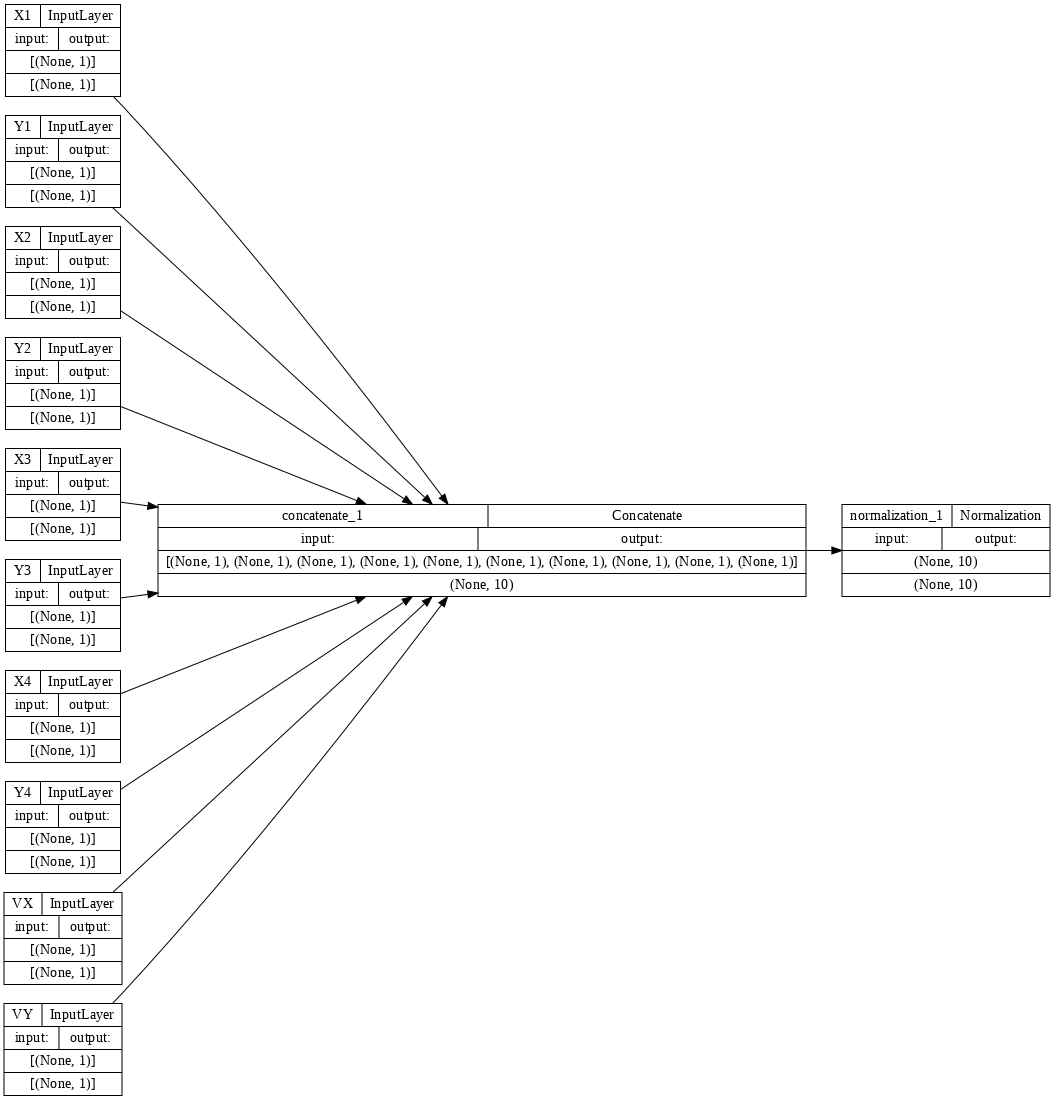

In [58]:
tf.keras.utils.plot_model(model = preprocessing_head, rankdir="LR", dpi=72, show_shapes=True, expand_nested=True, to_file="preprocessing_head.png")

## You can also see the preprocessed outputs for the given inputs

In [59]:
# preprocessing_head({
#     "sex" : np.array(["male"]),
#     "age" : np.array([22.0]),
#     "n_siblings_spouses" : np.array([1]),
#     "parch" : np.array([0]),
#     "fare" : np.array([7.25]),
#     "class" : np.array(["Third"]),
#     "deck" : np.array(["unknown"]),
#     "embark_town" : np.array(["Southampton"]),
#     "alone" : np.array(["n"]),
# })

# preprocessing_head({
#     "age" : np.array([22.0]),
#     "fare" : np.array([7.25]),
# })

## pass the model_inputs through the preprocessing_head

In [60]:
preprocessed_outputs = preprocessing_head(model_inputs)

In [61]:
num_preprocessed_outputs = list(preprocessed_outputs.shape)[-1]

In [62]:
num_preprocessed_outputs

10

## Find out how many batches should be used for training and how many for validation

In [63]:
dataset_size = 0

for _ in get_dataset(batch_size=BATCH_SIZE):
    dataset_size += 1

In [64]:
train_size = int(TRAIN_FRAC * dataset_size)

In [65]:
print(dataset_size)
print(train_size)

9
7


## Split the training and validation datasets


In [66]:
dataset = get_dataset(batch_size=BATCH_SIZE)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

## Set a caching mechanism that prefetches the next batch while the current batch is training

In [67]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## define early stopping and checkpointing callbacks

In [68]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR, "M.{epoch:02d}-{val_loss:.2f}"))

In [69]:
callbacks = [
    early_stopping_callback,
    checkpoint_callback,
]

In [70]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

## model builder function is used by keras-tuner to find the best parameters for a model

In [71]:
def model_builder(hp):
    if TASK == "r":
        loss_fn = "mean_absolute_error"
    elif TASK == "c":
        if OUTPUT_NODES == 1:
            loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        else:
            loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    if TASK == "r":
        metrics = None
    elif TASK == "c":
        metrics = ["accuracy"]

 
    kernel_hp = hp.Choice('kernel_regularization', values = [0.01, 0.001, 0.0001, 0.00001])
    activation_hp = hp.Choice("activation", values=["elu", "relu"])
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.01,
        decay_steps=train_size*1000,
        decay_rate=1,
        staircase=False
    )


    body = tf.keras.Sequential()
    current_nodes = num_preprocessed_outputs

    while current_nodes > OUTPUT_NODES:
        body.add(
            tf.keras.layers.Dense(current_nodes,
                                  kernel_regularizer=tf.keras.regularizers.l2(kernel_hp),
                                  activation=activation_hp)
        )
        body.add(tf.keras.layers.Dropout(0.1))

        current_nodes = current_nodes // 2

    body.add(tf.keras.layers.Dense(OUTPUT_NODES))

    result = body(preprocessed_outputs)
    
    model = tf.keras.Model(model_inputs, result)
    
    model.compile(loss=loss_fn, 
                  optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
                  metrics=metrics
    )
  
    return model



## initialize keras tuner

In [72]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'tuner_dir',
                     project_name = 'tuner')

In [73]:
tuner.search(
    train_dataset, 
    validation_data=val_dataset,
    epochs=10,
    callbacks = [ClearTrainingOutput()]
)

Trial 8 Complete [00h 00m 01s]
val_loss: 13.924071311950684

Best val_loss So Far: 11.928754806518555
Total elapsed time: 00h 00m 12s


In [74]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

## These are the best model parameters

In [75]:
best_hps.values

{'kernel_regularization': 1e-05,
 'activation': 'elu',
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

In [76]:
model = tuner.hypermodel.build(best_hps)

In [77]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 VX (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 VY (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 X1 (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 X2 (InputLayer)                [(None, 1)]          0           []                               
                                                                                            

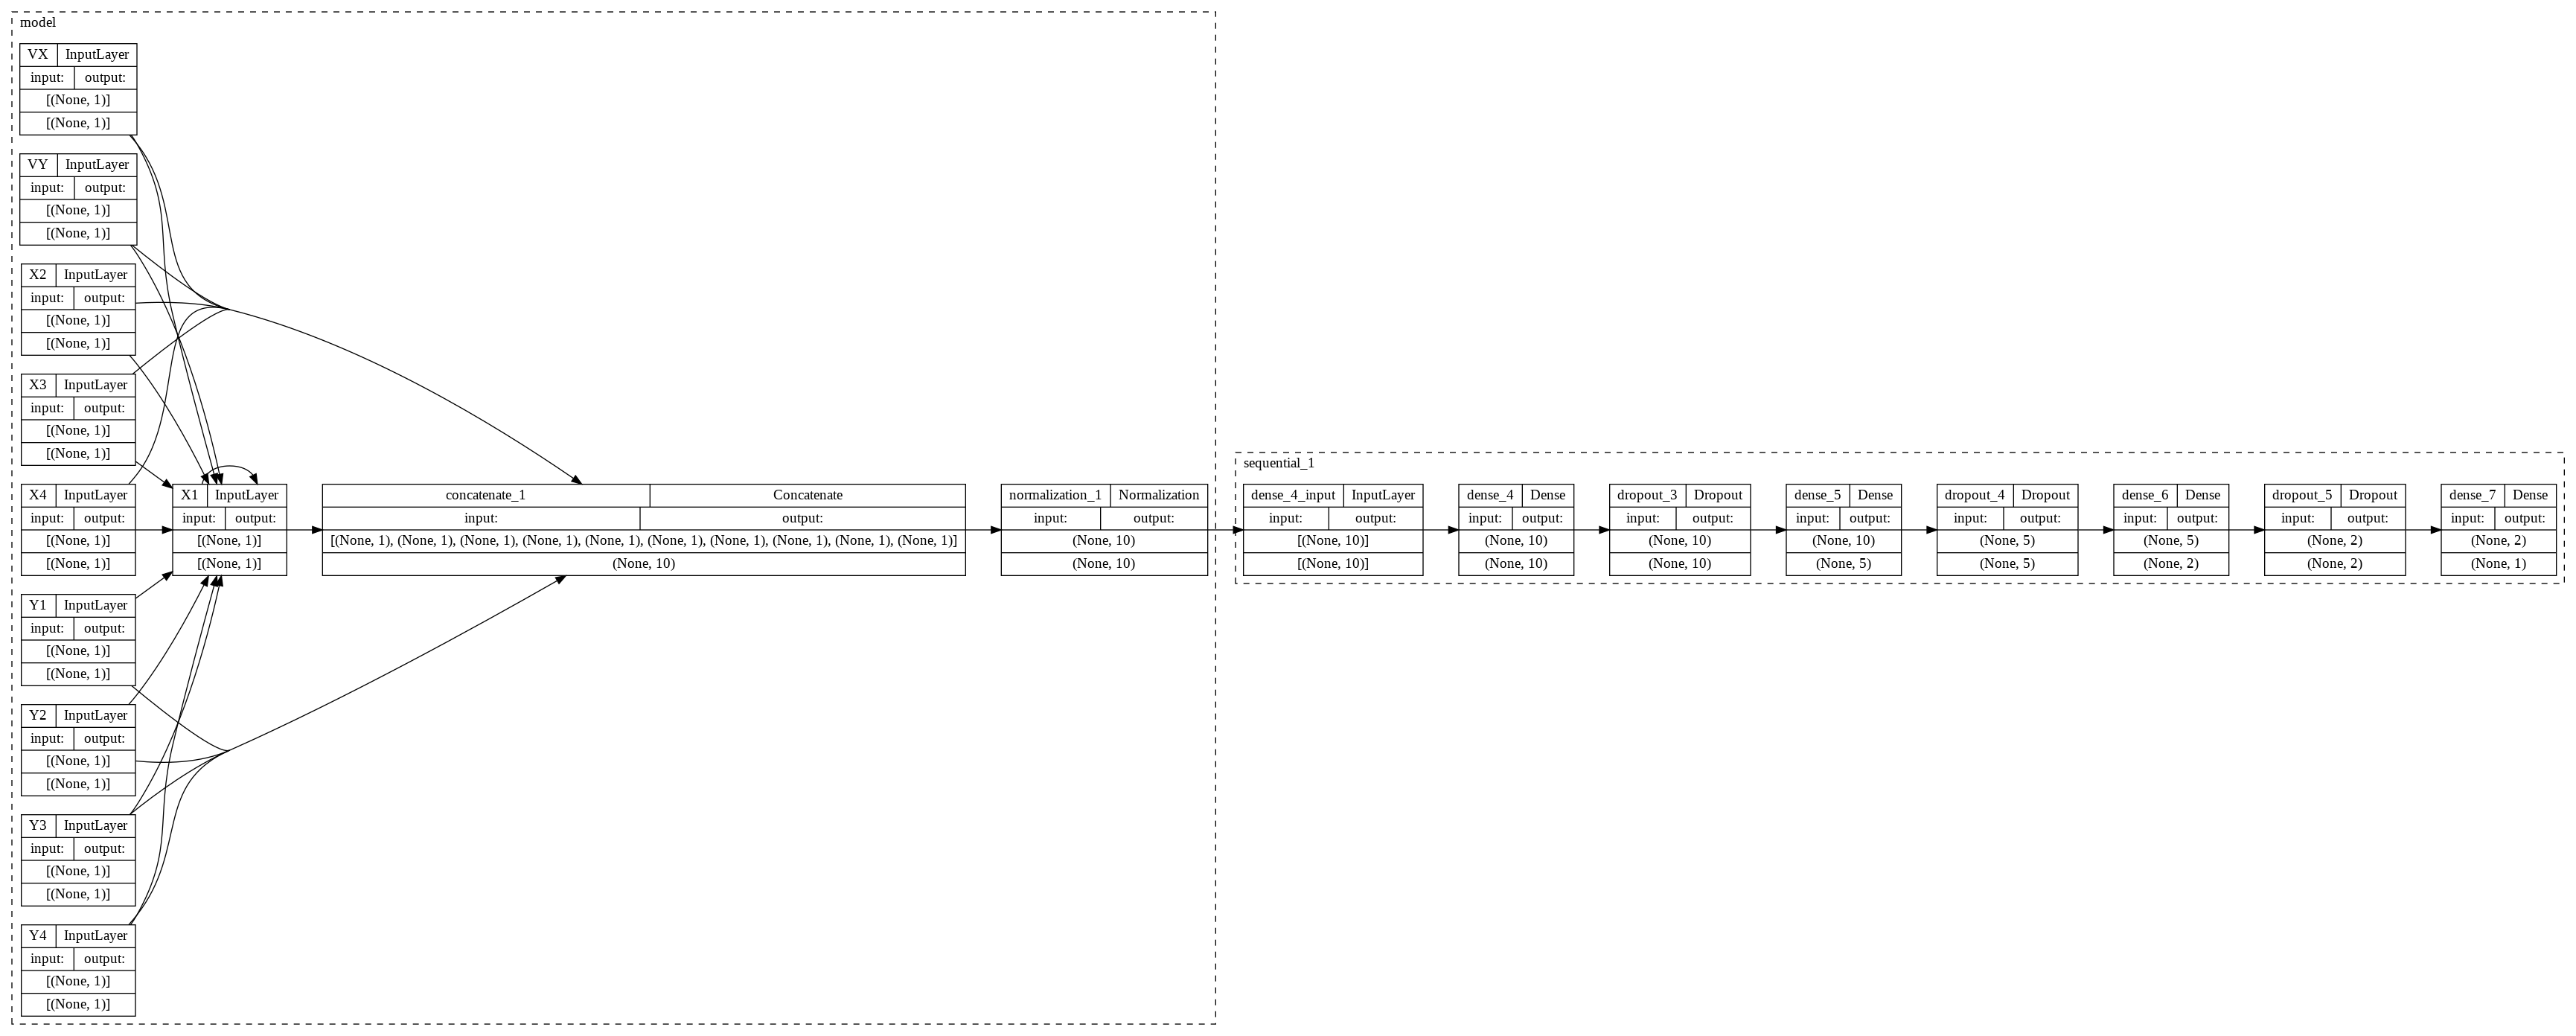

In [78]:
tf.keras.utils.plot_model(model = model, rankdir="LR", dpi=96, show_shapes=True, expand_nested=True, to_file="model.png")

## Find out training and validation losses with untrained model

In [79]:
# loss with un-trained model
model.evaluate(train_dataset)

7/7 [==============================] - 0s 8ms/step - loss: 14.3682


14.368179321289062

In [80]:
# val_loss with un-trained model
model.evaluate(val_dataset)

2/2 [==============================] - 0s 22ms/step - loss: 14.2135


14.213536262512207

## Train the model

In [81]:
history = model.fit(
    train_dataset, 
    validation_data=val_dataset,
    callbacks=callbacks,
    epochs=EPOCHS)

Epoch 1/100
      1/Unknown - 1s 501ms/step - loss: 14.2493

7/7 [==============================] - 2s 305ms/step - loss: 14.1074 - val_loss: 13.5513
Epoch 2/100
1/7 [===>..........................] - ETA: 0s - loss: 13.5633

7/7 [==============================] - 2s 309ms/step - loss: 13.2165 - val_loss: 12.4175
Epoch 3/100
1/7 [===>..........................] - ETA: 0s - loss: 12.5436

7/7 [==============================] - 2s 267ms/step - loss: 11.7938 - val_loss: 10.3791
Epoch 4/100
1/7 [===>..........................] - ETA: 0s - loss: 10.5827

7/7 [==============================] - 2s 310ms/step - loss: 9.8014 - val_loss: 7.9252
Epoch 5/100
1/7 [===>..........................] - ETA: 0s - loss: 8.1723

7/7 [==============================] - 3s 464ms/step - loss: 7.6873 - val_loss: 5.1358
Epoch 6/100
1/7 [===>..........................] - ETA: 0s - loss: 5.9182

7/7 [==============================] - 2s 274ms/step - loss: 6.2933 - val_loss: 4.4641
Epoch 7/100
1/7 [===>..........................] - ETA: 0s - loss: 6.9200

7/7 [==============================] - 2s 264ms/step - loss: 6.2234 - val_loss: 4.2397
Epoch 8/100
1/7 [===>..........................] - ETA: 0s - loss: 5.6670

7/7 [==============================] - 2s 310ms/step - loss: 5.5852 - val_loss: 4.3930
Epoch 9/100
1/7 [===>..........................] - ETA: 0s - loss: 5.1713

7/7 [==============================] - 2s 267ms/step - loss: 5.5909 - val_loss: 4.5999
Epoch 10/100
1/7 [===>..........................] - ETA: 0s - loss: 5.2793

7/7 [==============================] - 2s 266ms/step - loss: 5.4343 - val_loss: 4.3913
Epoch 11/100
1/7 [===>..........................] - ETA: 0s - loss: 5.2917

7/7 [==============================] - 2s 314ms/step - loss: 5.2198 - val_loss: 4.2806
Epoch 12/100
1/7 [===>..........................] - ETA: 0s - loss: 4.8436

7/7 [==============================] - 2s 265ms/step - loss: 5.2343 - val_loss: 4.4668


## Find out training and validation losses with trained model

In [82]:
# loss with trained model
model.evaluate(train_dataset)

7/7 [==============================] - 0s 6ms/step - loss: 4.4750


4.474972248077393

In [83]:
# val_loss with trained model
model.evaluate(val_dataset)

2/2 [==============================] - 0s 23ms/step - loss: 4.4668


4.46682071685791

In [84]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

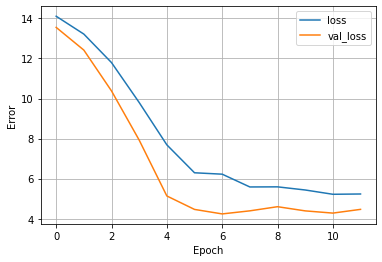

In [85]:
plot_loss(history)

In [86]:
def plot_acc(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid(True)

In [87]:
if TASK == "c":
    plot_acc(history)

## Test the model on some dummy data

In [88]:
# model.predict({
#     "sex" : np.array(["male"]),
#     "age" : np.array([22.0]),
#     "n_siblings_spouses" : np.array([1]),
#     "parch" : np.array([0]),
#     "fare" : np.array([7.25]),
#     "class" : np.array(["Third"]),
#     "deck" : np.array(["unknown"]),
#     "embark_town" : np.array(["Southampton"]),
#     "alone" : np.array(["n"]),
# })

In [89]:
# reloaded = tf.keras.models.load_model("models/titanic_model.24-1610.52")

In [90]:
# reloaded.evaluate(train_dataset)

In [91]:
# reloaded.evaluate(val_dataset)